In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
import seaborn as sns
sns.set_style("dark")
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

#from warnings import filterwarnings
#filterwarnings('ignore')

data=None
def absolute_correlations(col, df=data):
    #absolute_values = np.abs(df[col])
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs.sort_values('absol', ascending=False).drop('absol', axis=1).tail(len(corrs)-1)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('flavors_of_cacao.csv')

# Convert from string
data['Cocoa\nPercent'] = data['Cocoa\nPercent'].str.replace('%', '')
data['Cocoa\nPercent'] = data['Cocoa\nPercent'].astype(float)

data.head()

,Company (Maker-if known),Specific Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,A. Morin,Agua Grande,1876,2016,63.000,France,3.750,,Sao Tome
1,A. Morin,Kpime,1676,2015,70.000,France,2.750,,Togo
2,A. Morin,Atsane,1676,2015,70.000,France,3.000,,Togo
3,A. Morin,Akata,1680,2015,70.000,France,3.500,,Togo
4,A. Morin,Quilla,1704,2015,70.000,France,3.500,,Peru


In [3]:
# Only two are rated a 5/5
data['Rating'].sort_values(ascending=False).head(10)

78     5.000
86     5.000
123    4.000
1487   4.000
316    4.000
572    4.000
1699   4.000
1543   4.000
600    4.000
315    4.000
Name: Rating, dtype: float64

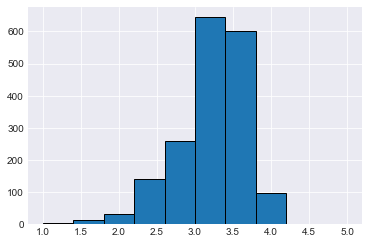

In [4]:
data['Rating'].hist(bins=10, edgecolor='black')

In [5]:
data[data['Rating'] == 5]

,Company (Maker-if known),Specific Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
78,Amedei,Chuao,111,2007,70.000,Italy,5.000,Trinitario,Venezuela
86,Amedei,Toscano Black,40,2006,70.000,Italy,5.000,Blend,


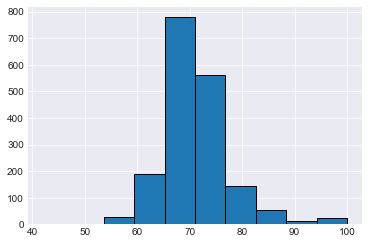

In [6]:
data['Cocoa\nPercent'].hist(bins=10, edgecolor='black')

# Ratings By Country

In [7]:
companies_per_country = data['Company\nLocation'].value_counts()

# Remove countries with a small sample size (< 5)
valid_countries = companies_per_country[companies_per_country > 4]

In [8]:
countries = data[data['Company\nLocation'].isin(valid_countries.index)]

In [9]:
countries.shape, data.shape

((1734, 9), (1795, 9))

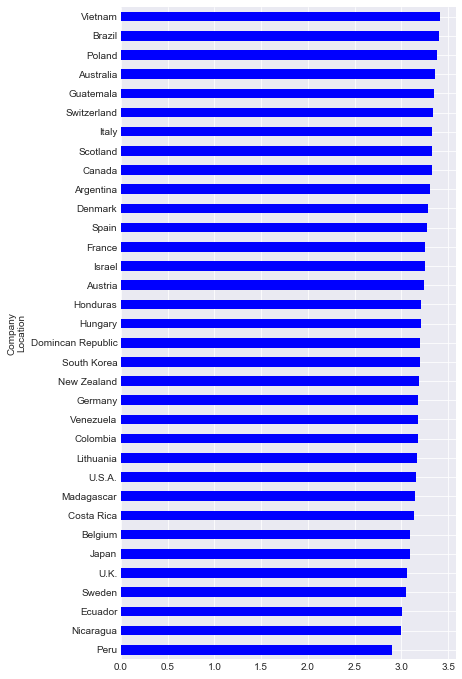

In [10]:
country_choc_ratings =\
countries.groupby('Company\nLocation')['Rating'].mean().sort_values()


country_choc_ratings.plot.barh(figsize=(6,12), grid=True, color='blue')

# Ratings By Bean Origin

In [11]:
exporters = data['Broad Bean\nOrigin'].value_counts()

# Remove countries with a small sample size (< 5)
valid_exporters = exporters[exporters > 10]

In [12]:
exporters = data[data['Broad Bean\nOrigin'].isin(valid_exporters.index)]

In [13]:
exporters.groupby('Broad Bean\nOrigin')['Rating'].mean()

Broad Bean\nOrigin
Belize               3.235
Bolivia              3.197
Brazil               3.284
Colombia             3.225
Costa Rica           3.145
Cuba                 3.250
Domincan Republic    3.190
Dominican Republic   3.209
Ecuador              3.135
Ghana                3.091
Grenada              3.026
Guatemala            3.321
Hawaii               3.214
Honduras             3.350
Indonesia            3.188
Jamaica              3.163
Madagascar           3.266
Mexico               3.008
Nicaragua            3.200
Papua New Guinea     3.292
Peru                 3.138
Tanzania             3.206
Trinidad             3.205
Venezuela            3.245
Vietnam              3.316
                     2.955
Name: Rating, dtype: float64

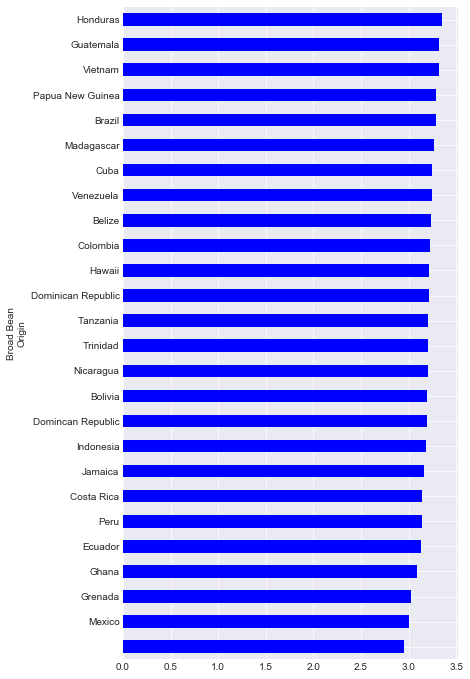

In [14]:
exporter_ratings =\
exporters.groupby('Broad Bean\nOrigin')['Rating'].mean().sort_values()


exporter_ratings.plot.barh(figsize=(6,12), grid=True, color='blue')

# Ratings by Bean Type

In [15]:
beans = data['Bean\nType'].value_counts()

# Remove small sample sizes
valid_beans = beans[beans > 10]

In [16]:
beans = data[data['Bean\nType'].isin(valid_beans.index)]

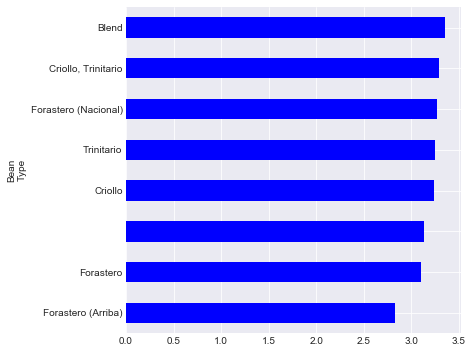

In [17]:
bean_ratings =\
beans.groupby('Bean\nType')['Rating'].mean().sort_values()


bean_ratings.plot.barh(figsize=(6,6), grid=True, color='blue')

# Cocoa Percent

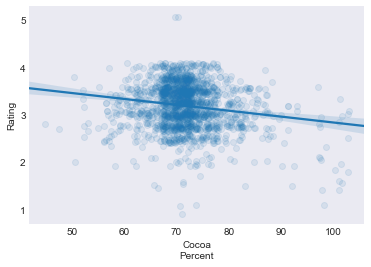

In [18]:
sns.regplot('Cocoa\nPercent', 'Rating', data=data,
           x_jitter=3, y_jitter=.1, scatter_kws=dict(alpha=0.1))

# Machine Learning

In [19]:
x = data.drop(['REF', 'Review\nDate', 'Rating'], axis=1)
x.fillna('None', inplace=True)

for col in x.select_dtypes(exclude='number').columns:
    lbl = LabelEncoder()
    x[col] = lbl.fit_transform(x[col])
    
y = data['Rating']

In [20]:
x = data.drop(['REF', 'Review\nDate', 'Rating'], axis=1)
x.fillna('None', inplace=True)

x = pd.get_dummies(x)
    
y = data['Rating']

In [21]:
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# I ran this earlier with more parameters
reg = XGBRegressor()
params = {'max_depth': [4, 5],
         'n_estimators': [65, 70, 75],
         'reg_lambda': list(np.arange(1.4, 1.7, .1))
         }
grid = GridSearchCV(reg, param_grid=params, cv=4, scoring='r2').fit(x, y)
reg = grid.best_estimator_

cv = cross_val_score(reg, x, y, cv=4, scoring='r2')

print(reg, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=70,
       n_jobs=1, nthread=1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1, seed=0,
       silent=True, subsample=1) 

Mean score: 0.0819096383253747
Std Dev:    0.020355351098704736


It looks like there actually aren't any strong predictors of chocolate quality -- our machine learning model works, but just barely. And when we see what's correlated with rating, nothing is especially high. (However, it's interesting how cocoa percentage is a negative correlation!)

In [23]:
data = pd.get_dummies(data)
absolute_correlations('Rating', df=data).head(10)

,correlation
Cocoa\nPercent,-0.165
Company \n(Maker-if known)_Soma,0.137
Company \n(Maker-if known)_Amedei,0.118
Specific Bean Origin\nor Bar Name_Sensations Intense,-0.108
Company \n(Maker-if known)_Cote d' Or (Kraft),-0.108
Specific Bean Origin\nor Bar Name_Baking,-0.108
Bean\nType_Forastero (Arriba),-0.108
REF,0.101
Bean\nType_,-0.100
Review\nDate,0.100
